https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
# money_df = pd.read_csv('M2SLMoneyStock.csv')
# spending_df = pd.read_csv('PCEPersonalSpending.csv')
# df = money_df.join(spending_df)

#df = money_df.concat(spending_df)

In [3]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

money_df = pd.read_csv('M2SLMoneyStock.csv')
spending_df = pd.read_csv('PCEPersonalSpending.csv')
df_concat = pd.merge(money_df, spending_df, on='Date', how='outer')
df_concat = pd.DataFrame(df_concat)
print(df_concat.shape)
print(df_concat.head())

(252, 3)
       Date   Money  Spending
0  1/1/1995  3492.4    4851.2
1  2/1/1995  3489.9    4850.8
2  3/1/1995  3491.1    4885.4
3  4/1/1995  3499.2    4890.2
4  5/1/1995  3524.2    4933.1


In [4]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
adf_test(df_concat['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [6]:
adf_test(df_concat['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
df_nodate = df_concat.drop(['Date'],axis=1)
df_difference = df_nodate.diff()

<AxesSubplot: >

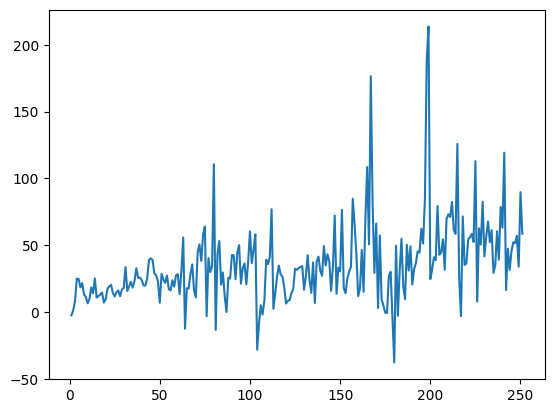

In [10]:
df_difference['Money'].plot()

In [11]:

adf_test(df_difference['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


<AxesSubplot: >

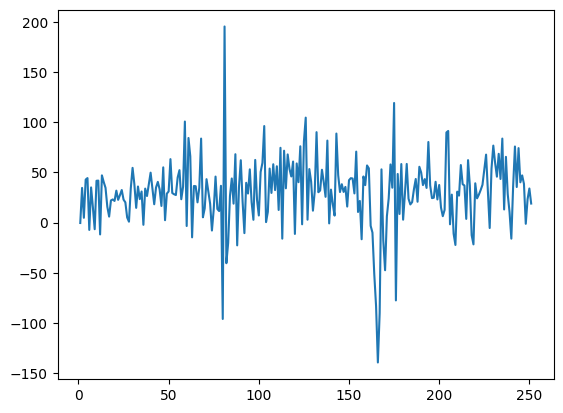

In [12]:
df_difference['Spending'].plot()

In [13]:
adf_test(df_difference['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [14]:
test_obs = 12
train = df_difference[:-test_obs]
test = df_difference[-test_obs:]

In [17]:
train

,Money,Spending
0,NaN,NaN
1,-2.5,-0.4
2,1.2,34.6
3,8.1,4.8
4,25.0,42.9
...,...,...
235,29.3,83.8
236,34.9,13.1
237,60.4,65.6
238,39.1,28.4


In [19]:
test

,Money,Spending
240,63.1,-16.0
241,119.2,36.4
242,16.4,75.9
243,47.3,35.5
244,31.5,74.3
245,45.5,40.2
246,52.2,47.1
247,51.5,38.6
248,57.0,-1.2
249,33.9,23.3


In [18]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
result = model.fit(5)
result.summary()

In [ ]:
lagged_Values = train.values[-8:]
pred = result.forecast(y=lagged_Values, steps=12) 

idx = pd.date_range('2015-01-01', periods=12, freq='MS')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['money_2d', 'spending_2d'])

In [ ]:
df_forecast['Money1d'] = (df['Money'].iloc[-test_obs-1]-df['Money'].iloc[-test_obs-2]) + df_forecast['money2d'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-test_obs-1] + df_forecast['Money1d'].cumsum()

In [ ]:
df_forecast['Spending1d'] = (df['Spending'].iloc[-test_obs-1]-df['Spending'].iloc[-test_obs-2]) + df_forecast['Spending2d'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-test_obs-1] + df_forecast['Spending1d'].cumsum()

In [ ]:
test_original = df[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)
test_original['Money'].plot(figsize=(12,5),legend=True)
df_forecast['MoneyForecast'].plot(legend=True)
